In [1]:
import os
import random
import re
from collections import Counter

import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import pandas as pd
import unicodedata
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from underthesea import word_tokenize

C:\Users\PC\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Robust File Loader (encoding fallbacks)

Loaded 42744 documents across 8 topics.


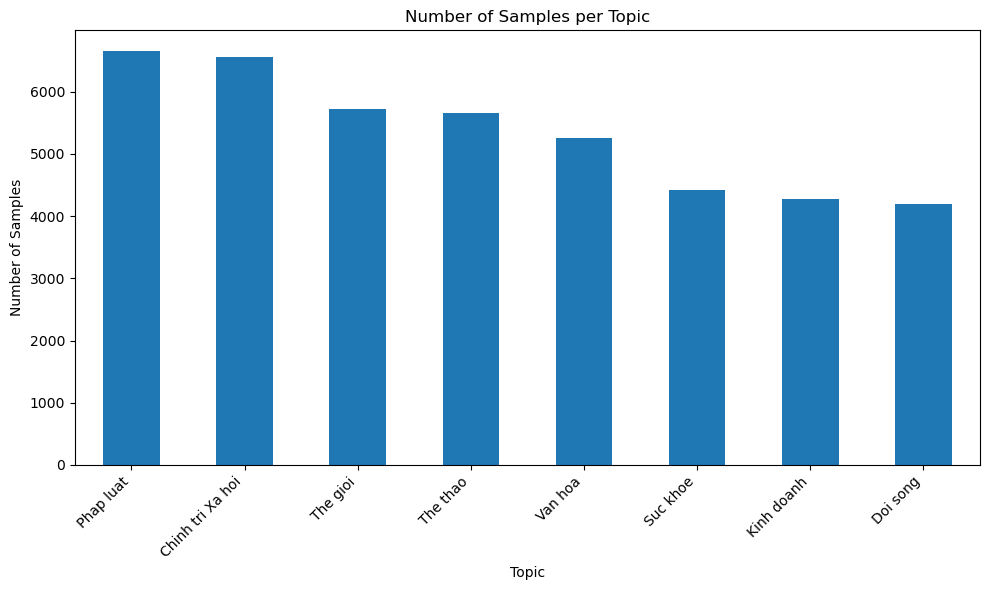

In [2]:
def read_text_file(path: str) -> str:
    """
    Fast reader:
      1) Try UTF-8 with errors='replace' (so you never get UnicodeDecodeError)
      2) If the result still looks badly garbled (optional check), fall back to Latin-1
    """
    # 1. Try UTF-8 with replacement of invalid bytes
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        text = f.read()
    # 2. Quick sanity check: if text is mostly replacement characters, switch to Latin-1
    #    (optional—remove this branch if you trust UTF-8)
    if text.count("\ufffd") / max(1, len(text)) > 0.01:
        with open(path, 'r', encoding='latin-1', errors='replace') as f:
            text = f.read()
    return text


# Load the eight-topic Vietnamese corpus
base_dir = './Train_Full'
records = []
for topic in os.listdir(base_dir):
    topic_path = os.path.join(base_dir, topic)
    if not os.path.isdir(topic_path):
        continue
    for fname in os.listdir(topic_path):
        if not fname.lower().endswith('.txt'):
            continue
        fullpath = os.path.join(topic_path, fname)
        txt = read_text_file(fullpath)
        # if file is empty after reading, skip
        if txt:
            records.append({'text': txt, 'label': topic})

df = pd.DataFrame(records)
print(f"Loaded {len(df)} documents across {df['label'].nunique()} topics.")

# Plot document counts per topic
topic_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Topic')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Topic')
plt.tight_layout()
plt.show()

In [3]:
# Encode labels and split raw data
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])
X_raw = df['text']
y = df['label_id']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)
# 2. Raw-Model Pipeline (no preprocessing)
raw_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])
raw_pipeline.fit(Xr_train, yr_train)
yr_pred = raw_pipeline.predict(Xr_test)
acc_raw = accuracy_score(yr_test, yr_pred)

3. Encode Labels & Train/Test Split

In [13]:

# Clean and tokenize full corpus
with open('vietnamese-stopwords.txt', encoding='utf-8') as f:
    VI_STOPWORDS = set(w.strip() for w in f if w.strip())
# Pre‐compile regexes once
EMOJI_RE    = re.compile("[\U0001F600-\U0001F64F" "\U0001F300-\U0001F5FF" "\U0001F680-\U0001F6FF" "\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
REPEAT_PUNC = re.compile(r'([!?.,])\1+')
CONTROL_RE  = re.compile(r'[\x00-\x1F\x7F]+')

def clean_and_tokenize(text):
    # 1) Clean
    t = unicodedata.normalize('NFC', text).lower()
    t = re.sub(r'http\S+|www\.\S+|\S+@\S+|\d+', ' ', t)
    t = re.sub(r'[^\w\s]', ' ', t)
    t = EMOJI_RE.sub(' ', t)
    t = REPEAT_PUNC.sub(r'\1', t)
    t = CONTROL_RE.sub(' ', t)
    # 2) Tokenize & filter stopwords
    toks = word_tokenize(t, format='text').split()
    return [w for w in toks if w not in VI_STOPWORDS]

# Run in parallel on all texts
texts = df['text'].tolist()
tokens_list = Parallel(n_jobs=-1, verbose=5)(
    delayed(clean_and_tokenize)(txt) for txt in texts
)

df['tokens'] = tokens_list

X_tok = df['tokens']
Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_tok, y, test_size=0.2, stratify=y, random_state=42
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3648 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4872 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7752 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9186 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9642 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 10236 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 11280 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12047 tasks    

4. Contextual Synonym Augmentation (multilingual BERT)

After augmentation, train size: 42600


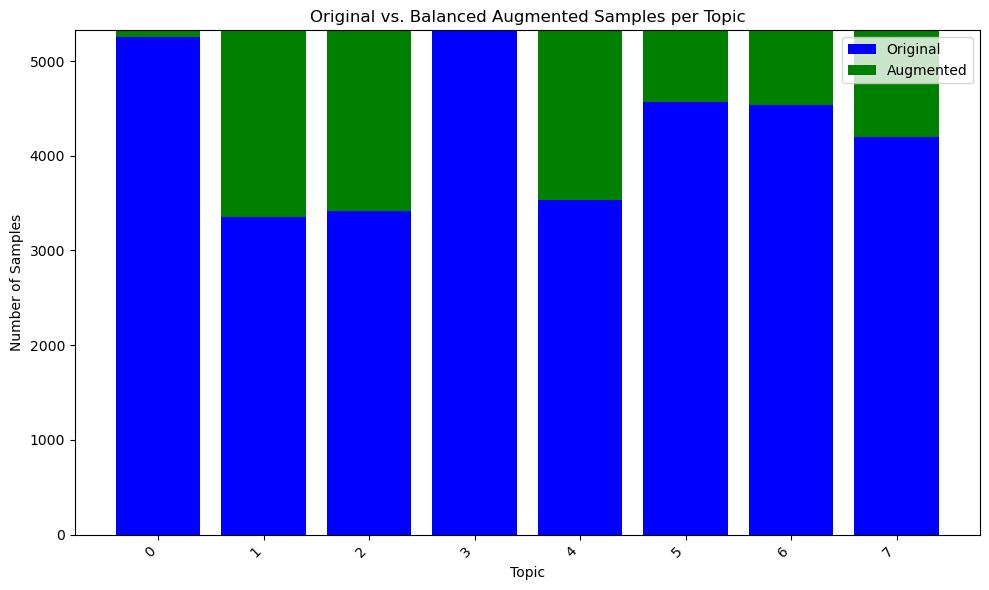

In [5]:
syn_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-cased',  # Vietnamese support
    action='substitute',  # token substitution
    top_k=5,  # candidate pool
    aug_p=0.3,  # 30% tokens per sentence
    aug_min=1,  # at least 1 token
    aug_max=3,  # at most 3 tokens
    device='cuda'  # or 'cuda'
)
orig_counts = Counter(yt_train)
max_count = max(orig_counts.values())

aug_texts, aug_labels = [], []

for topic, count in orig_counts.items():
    needed = max_count - count
    # Get all samples of this topic
    samples = [tokens for tokens, lbl in zip(Xt_train, yt_train) if lbl == topic]
    for _ in range(needed):
        toks = random.choice(samples)
        sent = ' '.join(toks)
        aug_sent = syn_aug.augment(sent, n=1)[0]
        aug_texts.append(aug_sent.split())
        aug_labels.append(topic)

Xt_train = list(Xt_train) + aug_texts
yt_train = list(yt_train) + aug_labels
print("After augmentation, train size:", len(Xt_train))

topics = list(orig_counts.keys())
orig_vals = [orig_counts[t] for t in topics]
aug_vals = [max_count - orig_counts[t] for t in topics]

plt.figure(figsize=(10, 6))
plt.bar(topics, orig_vals, color='blue', label='Original')
plt.bar(topics, aug_vals, bottom=orig_vals, color='green', label='Augmented')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Topic')
plt.ylabel('Number of Samples')
plt.title('Original vs. Balanced Augmented Samples per Topic')
plt.legend()
plt.tight_layout()
plt.show()

6. Pipeline Assembly & Training

In [7]:
mi_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)),
    ('pca', PCA(n_components=100)),  # Feature Extraction
    ('select', SelectKBest(score_func=mutual_info_classif, k=50)),  # Feature Selection
    ('clf', LogisticRegression(max_iter=1000))
])

mi_pipeline.fit([' '.join(t) for t in Xt_train], yt_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))),
                ('pca', PCA(n_components=100)),
                ('select',
                 SelectKBest(k=50,
                             score_func=<function mutual_info_classif at 0x0000020C88D6C4A0>)),
                ('clf', LogisticRegression(max_iter=1000))])

In [12]:
chi2_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9, min_df=5
    )),
    ('chi2', SelectKBest(chi2, k=2000)),
    ('clf', LogisticRegression(max_iter=1000))
])

chi2_pipeline.fit([' '.join(t) for t in Xt_train], yt_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))),
                ('chi2',
                 SelectKBest(k=2000,
                             score_func=<function chi2 at 0x0000020C88D6E520>)),
                ('clf', LogisticRegression(max_iter=1000))])

7. Save Pipeline & Artifacts

 8. Evaluation

In [10]:
yp_chi2_pred = chi2_pipeline.predict([' '.join(t) for t in Xt_test])
acc_pp_chi2 = accuracy_score(yt_test, yp_chi2_pred)
yp_mi_pred = mi_pipeline.predict([' '.join(t) for t in Xt_test])
acc_mi = accuracy_score(yt_test, yp_mi_pred)

print("=== Model Comparison ===")
print(f"Raw-Model Test Accuracy        : {acc_raw:.4f}")
print(f"Preprocessed-Model with Chi2 Test Accuracy: {acc_pp_chi2:.4f}")
print(f"Preprocessed-Model with Mi Test Accuracy: {acc_mi:.4f}")

print("\n-- Raw-Model Classification Report --")
print(classification_report(yr_test, yr_pred, target_names=le.classes_))
print("\n-- Preprocessed-Model with Chi2 Classification Report --")
print(classification_report(yt_test, yp_chi2_pred, target_names=le.classes_))
print("\n-- Preprocessed-Model with Mi Classification Report --")
print(classification_report(yt_test, yp_mi_pred, target_names=le.classes_))


=== Model Comparison ===
Raw-Model Test Accuracy        : 0.2254
Preprocessed-Model with Chi2 Test Accuracy: 0.8647
Preprocessed-Model with Mi Test Accuracy: 0.8078

-- Raw-Model Classification Report --
                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.19      0.34      0.25      1314
        Doi song       0.14      0.15      0.14       839
      Kinh doanh       0.25      0.16      0.19       855
       Phap luat       0.30      0.42      0.35      1331
        Suc khoe       0.27      0.01      0.03       883
        The gioi       0.22      0.35      0.27      1143
        The thao       0.26      0.14      0.18      1134
         Van hoa       0.21      0.09      0.13      1050

        accuracy                           0.23      8549
       macro avg       0.23      0.21      0.19      8549
    weighted avg       0.23      0.23      0.20      8549


-- Preprocessed-Model with Chi2 Classification Report --
                  precision    recall  